# 

**Beyond Balanced: Learning Static Search Trees with Tree-MDPs**

Train an Agent to Generate a Learned Binary Search Tree for your Query
Distribution!

<figure>
<a
href="https://colab.research.google.com/drive/14xJRrsmpogzx1_ktF5cDSswoIRJvdp0g?usp=sharing"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

In [ ]:
# For rendering the saved PDF figures in Colab
%%capture
%pip install pdf2image
!apt-get install poppler-utils

In [ ]:
# @title Imports
from __future__ import annotations

import os
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple, DefaultDict

from abc import ABC, abstractmethod
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from tqdm import tqdm

# Show warnings only once
import warnings
warnings.filterwarnings("default")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Widgets and Plotting
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from graphviz import Digraph
from pdf2image import convert_from_path


to_np = lambda x: x.detach().cpu().numpy()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()

In [ ]:
# @title Query Distribution Base Class


class QueryDistribution(ABC):
    """
    Base class for query distributions over a set of unique keys.
    Subclasses must implement _sample_single_key.
    """
    def __init__(self, query_range_min: int, query_range_max: int, arr_size: int, params: Optional[Dict[str, Any]] = None,
                 min_samples: int = 10_000, max_attempts: int = 100_000):
        """Initialize a query distribution.

        Args:
            query_range_min: Minimum value of the query range (inclusive)
            query_range_max: Maximum value of the query range (exclusive)
            arr_size: Number of unique keys to generate
            params: Optional dictionary of distribution-specific parameters
            min_samples: Minimum number of samples to generate
            max_attempts: Maximum number of attempts to generate samples
        """
        self.query_range_min = query_range_min
        self.query_range_max = query_range_max
        self.arr_size = arr_size
        self.params = params if params is not None else {}
        self.min_samples = min_samples
        self.max_attempts = max_attempts
        self._unique_keys = None
        self._key_counts = None

    @abstractmethod
    def _sample_single_key(self) -> int:
        """Sample a single key according to the distribution."""
        pass

    def sample_keys(self) -> Tuple[np.ndarray, Dict[int, int]]:
        """
        Generates integer queries from the distribution.

        Returns:
            Tuple containing:
                - np.ndarray: Sorted array of unique sampled keys
                - Dict[int, int]: Dictionary mapping each key to its count
        """
        unique_keys_set = set()
        key_counts = defaultdict(int)
        collected_samples = 0

        with tqdm(total=self.min_samples, desc="Sampling query distribution") as pbar:
            attempt = 0
            while (len(unique_keys_set) < self.arr_size or collected_samples < self.min_samples) and attempt < self.max_attempts:
                queried_key = self._sample_single_key()
                attempt += 1

                if self.query_range_min <= queried_key < self.query_range_max:
                    unique_keys_set.add(queried_key)
                    key_counts[queried_key] += 1
                    collected_samples += 1
                    pbar.update(1)

                # Update progress even when we exceed min_samples to show progress toward array size
                pbar.set_postfix({
                    "collected": collected_samples,
                    "unique": len(unique_keys_set),
                    "target_unique": self.arr_size
                })

        if len(unique_keys_set) < self.arr_size:
            raise ValueError(f"Failed to generate the required number of unique keys ({self.arr_size}).")

        if len(unique_keys_set) > self.arr_size:
            sorted_unique_keys_list = sorted(list(unique_keys_set))
            probs = np.array([key_counts[k] for k in sorted_unique_keys_list], dtype=float)
            probs /= probs.sum()

            selected_keys_list = np.random.choice(
                sorted_unique_keys_list,
                size=self.arr_size,
                replace=False,
                p=probs
            )
            unique_keys_set = set(selected_keys_list)

            new_counts = defaultdict(int)
            for key in unique_keys_set:
                new_counts[key] = key_counts[key]
            key_counts = new_counts

        final_unique_keys = np.sort(np.array(list(unique_keys_set)))
        self._unique_keys = final_unique_keys
        self._key_counts = key_counts
        return final_unique_keys, key_counts

    @property
    def requests(self) -> np.ndarray:
        """
        Get the full array of requests based on sampled keys and their frequencies.

        Returns:
            np.ndarray: Array containing all requests with proper frequencies
        """
        if self._unique_keys is None or self._key_counts is None:
            raise ValueError("Cannot access requests before calling sample_keys()")

        requests = []
        for key in self._unique_keys:
            requests.extend([key] * self._key_counts[key])
        return np.array(requests)

In [ ]:
# @title Query Distributions for Experimentation: Uniform, Gaussian, GaussianMixture, Exponential

class UniformQueryDistribution(QueryDistribution):
    """Uniform query distribution."""
    def _sample_single_key(self) -> int:
        return np.random.randint(self.query_range_min, self.query_range_max)


class GaussianQueryDistribution(QueryDistribution):
    """
    Gaussian query distribution.

    Args:
        mean: Normalized mean of the Gaussian (0-1)
        std: Normalized standard deviation of the Gaussian (0-1)
    """
    def _sample_single_key(self) -> int:
        range_span = self.query_range_max - self.query_range_min

        mean_val = self.query_range_min + self.params.get("mean", 0.5) * range_span
        std_val = max(self.params.get("std", 0.2) * range_span, 1e-6 * range_span)

        key = np.random.normal(mean_val, std_val)
        return round(key)


class GaussianMixtureQueryDistribution(QueryDistribution):
    """
    Bimodal Gaussian mixture query distribution.

    Args:
        mean1: Normalized mean of first Gaussian (0-1)
        std1: Normalized standard deviation of first Gaussian (0-1)
        mean2: Normalized mean of second Gaussian (0-1)
        std2: Normalized standard deviation of second Gaussian (0-1)
        weight1: Weight of first Gaussian (0-1)
    """
    def _sample_single_key(self) -> int:
        range_span = self.query_range_max - self.query_range_min
        m1 = self.query_range_min + self.params.get("mean1", 0.25) * range_span
        s1 = max(self.params.get("std1", 0.1) * range_span, 1e-6 * range_span)
        m2 = self.query_range_min + self.params.get("mean2", 0.75) * range_span
        s2 = max(self.params.get("std2", 0.1) * range_span, 1e-6 * range_span)
        w1 = self.params.get("weight1", 0.5)
        if np.random.random() < w1:
            key = np.random.normal(m1, s1)
        else:
            key = np.random.normal(m2, s2)
        return round(key)


class ExponentialQueryDistribution(QueryDistribution):
    """
    Exponential query distribution.

    Args:
        scale: Scale parameter of the exponential distribution. Default 1.0.
    """
    def _sample_single_key(self) -> int:
        scale = self.params.get("scale", 1.0)
        range_span = self.query_range_max - self.query_range_min
        effective_scale = (range_span / np.log(100)) * (1.0 / scale)

        key = self.query_range_min + int(np.floor(np.random.exponential(effective_scale)))
        return round(key)

In [ ]:
# @title Helper Functions for Plotting

def display_figures(experiment: Experiment, width: int = 700):
    """Shows all saved PDF files in the results dir, scaled to a given width.

    Args:
        experiment: The Experiment instance
        width: Desired width of the image in pixels (height is scaled to preserve aspect ratio)
    """
    for filename in os.listdir(experiment.config.results_dir):
        filepath = os.path.join(os.getcwd(), experiment.config.results_dir, filename)
        if filename.lower().endswith(".pdf"):
            # Convert first page of PDF to image
            pdf_img = convert_from_path(filepath)[0]

            # Resize to desired width and keep the aspect ratio
            w_percent = width / float(pdf_img.size[0])
            h_size = int(float(pdf_img.size[1]) * w_percent)
            resized_img = pdf_img.resize((width, h_size), Image.Resampling.LANCZOS)
            print(f"Figure {filepath}:")
            display(resized_img)


def plot_query_distribution(env, filename="figures/query_distribution"):
    """Plots the distribution of queried keys and their counts.

    Args:
        env: The TreeMDP environment instance
        filename: Path to save the plot
    """
    plt.figure(figsize=(10, 6))
    plt.bar(env.unique_keys, [env.key_counts[k] for k in env.unique_keys])
    plt.title(f"Distribution of Queried Keys ({env.query_distribution.__class__.__name__})")
    plt.xlabel("Key Value")
    plt.ylabel("Count")

    # Save the plot
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"{filename}.pdf")
    plt.close()


def plot_training_metrics(experiment) -> None:
    """Creates and saves plots of training metrics.

    Args:
        experiment: The Experiment instance containing training metrics
    """
    print("Plotting training metrics")

    # Metrics vs. Episodes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    episodes_axis = np.arange(len(experiment.critic_losses))

    # Subplot 1: Losses
    ax1.plot(episodes_axis, experiment.critic_losses, label="Critic Loss", alpha=0.7)
    ax1.plot(episodes_axis, experiment.actor_losses, label="Actor Loss", alpha=0.7)
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Subplot 2: Root Node Returns
    ax2.plot(
        episodes_axis,
        experiment.root_node_returns,
        label="Root Node Return (Raw)",
        alpha=0.3,
    )
    if len(experiment.root_node_returns) >= experiment.config.plot_rolling_window:
        returns_moving_avg = (
            np.convolve(
                experiment.root_node_returns,
                np.ones(experiment.config.plot_rolling_window),
                mode="valid",
            )
            / experiment.config.plot_rolling_window
        )
        ax2.plot(
            episodes_axis[experiment.config.plot_rolling_window - 1 :],
            returns_moving_avg,
            label=f"Root Node Return (Roll Avg {experiment.config.plot_rolling_window})",
        )
    ax2.set_ylabel("Return")
    ax2.legend()
    ax2.set_title("Root Node Split Returns")

    # Subplot 3: Mean Entropy
    ax3.plot(episodes_axis, experiment.mean_entropies, label="Mean Policy Entropy")
    ax3.set_xlabel("Episode")
    ax3.set_ylabel("Entropy")
    ax3.legend()
    ax3.set_title("Mean Policy Entropy")

    plt.tight_layout()
    metrics_plot_filename = os.path.join(experiment.config.results_dir, "training_metrics.pdf")
    plt.savefig(metrics_plot_filename)
    plt.close(fig)
    print(f"Training metrics saved to {metrics_plot_filename}")

    # Action and Policy Distribution Heatmaps (vs. Timestep)
    if experiment.action_history and experiment.policy_distribution_history:
        fig_actions, (ax_action, ax_policy) = plt.subplots(1, 2, figsize=(18, 7))

        # Action Heatmap
        # Discretize continuous actions for heatmap visualization (e.g., into 100 bins)
        num_action_bins = 100
        action_matrix = np.zeros((len(experiment.action_history), num_action_bins))
        for i, action_val in enumerate(experiment.action_history):
            bin_idx = min(int(action_val * num_action_bins), num_action_bins - 1)
            action_matrix[i, bin_idx] = 1

        ax_action.matshow(action_matrix, aspect="auto", cmap="viridis")
        ax_action.set_title("Selected Actions Over Time (Continuous to Bins)")
        ax_action.set_xlabel(f"Action Bins (0 to 1, in {num_action_bins} bins)")
        ax_action.set_ylabel("Global Timestep")

        # Policy Distribution Heatmap
        policy_matrix = np.array(experiment.policy_distribution_history)
        im_policy = ax_policy.matshow(policy_matrix, aspect="auto", cmap="viridis")
        ax_policy.set_title("Policy Distribution Over Time")
        # Adjust x-ticks to show normalized action values if n_actions is available
        if experiment.n_actions > 0:
            tick_positions = np.linspace(0, experiment.n_actions - 1, min(experiment.n_actions, 5), dtype=int)
            tick_labels = np.round(
                tick_positions / (experiment.n_actions - 1) if experiment.n_actions > 1 else [0.0],
                2,
            )
            ax_policy.set_xticks(tick_positions)
            ax_policy.set_xticklabels(tick_labels)
        ax_policy.set_xlabel("Normalized Action")
        ax_policy.set_ylabel("Global Timestep")
        plt.colorbar(im_policy, ax=ax_policy)  # Add colorbar correctly for this subplot

        plt.tight_layout()
        action_history_plot_filename = os.path.join(experiment.config.results_dir, "action_policy_history.pdf")
        plt.savefig(action_history_plot_filename)
        plt.close(fig_actions)
        print(f"Action and policy history plotted to {action_history_plot_filename}")
    else:
        print("Skipping action/policy history plots as no data was recorded")


def plot_optimality(
    optimality_percentages: List[float],
    window_size: int,
    results_dir: str,
    final_greedy_optimality: float,
) -> None:
    """Plot the optimality percentage over training episodes.

    Args:
        optimality_percentages: List of optimality percentages from training episodes
        window_size: Size of the rolling window for smoothing
        results_dir: Directory to save the plot
        final_greedy_optimality: Optimality percentage from the final greedy evaluation
    """
    plt.figure(figsize=(10, 6))
    episodes = range(1, len(optimality_percentages) + 1)

    # Plot raw data with low alpha
    plt.plot(
        episodes,
        optimality_percentages,
        alpha=0.3,
        color="tab:blue",
        label="Training (Raw)",
    )

    # Plot smoothed data
    window_size = min(window_size, len(optimality_percentages))
    smoothed = np.convolve(optimality_percentages, np.ones(window_size) / window_size, mode="valid")
    plt.plot(
        range(window_size, len(episodes) + 1),
        smoothed,
        color="tab:blue",
        label=f"Training (Moving Average, window={window_size})",
    )

    # Plot optimal BST reference line
    plt.axhline(y=100, color="tab:red", linestyle="--", label="Optimal BST")

    # Plot final greedy evaluation
    plt.axhline(
        y=final_greedy_optimality,
        color="tab:green",
        linestyle="--",
        label=f"Final Greedy Evaluation ({final_greedy_optimality:.1f}%)",
    )

    plt.xlabel("Episode")
    plt.ylabel("Optimality (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save the plot
    plt.savefig(os.path.join(results_dir, "optimality.pdf"))
    plt.close()
    print(f"Optimality plot saved to {os.path.join(results_dir, 'optimality.pdf')}")


def plot_optimal_bst(optimal_tree: SearchTreeNode, filename: str = "figures/optimal_bst"):
    """Plots the optimal BST (from Knuth's algorithm) using graphviz's Digraph and saves as PDF.

    Args:
        optimal_tree: The root node of the optimal BST (SearchTreeNode)
        filename: Path to save the plot
    """
    dot = Digraph(format="pdf")

    def add_nodes_edges(node):
        if node is None:
            return
        label = f"{node.split_element}\nCount: {node.num_split_element}"
        dot.node(str(id(node)), label)
        if node.left_child:
            dot.edge(str(id(node)), str(id(node.left_child)))
            add_nodes_edges(node.left_child)
        if node.right_child:
            dot.edge(str(id(node)), str(id(node.right_child)))
            add_nodes_edges(node.right_child)

    add_nodes_edges(optimal_tree)

    os.makedirs("figures", exist_ok=True)
    try:
        dot.render(filename, view=False)
        print(f"Saved optimal BST plot to {filename}.pdf")
    except Exception as e:
        print(f"Error plotting optimal BST. Try `conda install -c conda-forge graphviz`.")


def plot_tree(env, root_node=None, filename: str = "figures/search_tree"):
    """Plots the tree using graphviz's Digraph and saves as PDF.

    Args:
        env: The TreeMDP environment instance
        root_node: The root node to start plotting from, defaults to env.root_node
        filename: Path to save the plot
    """
    if root_node is None:
        root_node = env.root_node

    dot = Digraph(format="pdf")

    # Helper function to add nodes and edges to the graph
    def add_nodes_edges(node):
        if node is None:
            return
        label = f"{node.key if node.key is not None else ''}"
        if node.key is not None:
            label += f"\nQuery Count: {env.key_counts[node.key]}"
        dot.node(str(id(node)), label)
        if node.left_child:
            dot.edge(str(id(node)), str(id(node.left_child)))
            add_nodes_edges(node.left_child)
        if node.right_child:
            dot.edge(str(id(node)), str(id(node.right_child)))
            add_nodes_edges(node.right_child)

    # Start the traversal from the root node
    add_nodes_edges(root_node)

    # Save the plot
    os.makedirs("figures", exist_ok=True)
    try:
        dot.render(filename, view=False)
        print(f"Saved tree plot to {filename}.pdf")
    except Exception as e:
        print(f"Error plotting tree. Try `conda install -c conda-forge graphviz`.")

In [ ]:
# @title Tree-MDP

@dataclass
class Node:
    """
    A node in the binary search tree representing a split point.

    Attributes:
        left: Left boundary of the node's range (inclusive)
        right: Right boundary of the node's range (inclusive)
        parent: Parent node in the tree
        left_child: Left child node
        right_child: Right child node
        key: Key value from unique_keys this node is split on
        subtree_node_distances: Dictionary mapping keys to their distances relative to the subtree root node
        subtree_node_counts: Dictionary mapping keys to their counts in the subtree
        cost: Total cost of the subtree rooted at this node
    """
    left: int
    right: int
    parent: Optional[Node] = None
    left_child: Optional[Node] = None
    right_child: Optional[Node] = None
    key: Optional[int] = None  # The key to split on. Results in child subtrees left=[0, key] and right=[key+1, right]
    subtree_node_distances: DefaultDict[int, int] = field(default_factory=lambda: defaultdict(int))
    subtree_node_counts: DefaultDict[int, int] = field(default_factory=lambda: defaultdict(int))
    cost: float = 0.0


class TreeMDP:
    """
    A Tree Markov Decision Process (Tree-MDP) in which we learn to construct binary search trees.

    The agent's goal is to build a binary search tree that minimizes the expected search cost
    given a distribution of queries. At each step, the agent chooses where to split the
    current node's range, creating left and right child nodes.
    This creates two child subproblems, which are solved recursively.
    """
    def __init__(
        self,
        query_distribution: QueryDistribution,
    ):
        """
        Initialize the TreeMDP environment.

        Args:
            query_distribution: Distribution object that generates key queries
        """
        self.query_distribution = query_distribution
        self.arr_size = self.query_distribution.arr_size
        if self.arr_size < 4:
            raise ValueError("arr_size (from query_distribution) has to be at least 4.")

        self.unique_keys, self.key_counts = self.query_distribution.sample_keys()
        self.keys_covered_by_tree: List[int] = []

        self.reset()

    def reset(self) -> tuple[np.ndarray, bool]:
        """
        Resets the constructed search tree.

        Returns:
            Tuple containing:
                - obs (np.ndarray): Initial observation [left, right] boundaries
                - done (bool): Whether the episode is complete
        """
        self.steps_taken = 0
        self.queue: List[Node] = []
        self.keys_trajectory: List[int] = []
        self.keys_covered_by_tree = []
        self.root_node = Node(left=0, right=self.arr_size - 1)  # Split index is inclusive [left, right]
        self.current_node = self.root_node
        obs = np.array([self.current_node.left, self.current_node.right])
        done = self.is_done()
        return obs, done


    def is_leaf_node(self, node: Node) -> bool:
        """Checks if a node is a leaf node (has no children)."""
        return node.left_child is None and node.right_child is None

    def tree_is_complete(self) -> bool:
        """Checks if the current generated binary search tree covers all unique keys."""
        # Check that that the union of all 1-element leaf nodes fully covers the array
        complete = np.all(np.isin(self.unique_keys, self.keys_covered_by_tree))
        return bool(complete)

    def is_done(self) -> bool:
        return self.tree_is_complete()

    def step(self, action: float) -> tuple[np.ndarray, bool]:
        """
        Takes a step in the environment by splitting the current node.

        Args:
            action: Normalized split action in [0, 1] where to split the current node's range

        Returns:
            Tuple containing:
                - obs (np.ndarray): Next observation [left, right] boundaries
                - done (bool): Whether the episode is complete
        """
        self.steps_taken += 1

        # Discretize action to idx. Action: [0-1]
        split_idx = round(self.current_node.left + action * (self.current_node.right - self.current_node.left))

        # Set the split key to the based on the split_idx
        split_key = self.unique_keys[split_idx]
        self.keys_covered_by_tree.append(split_key)
        self.current_node.key = split_key  # Split key of the current node

        # Create the left and right children and add them to the queue (-> BFS)
        if split_idx - 1 >= self.current_node.left:
            # Add left child child if there are uncovered keys left to the split_idx
            left_child = Node(
                parent=self.current_node,
                left=self.current_node.left,
                right=split_idx - 1,
            )
            self.current_node.left_child = left_child
            if left_child.left != left_child.right:
                # Add non-leaf nodes to queue
                self.queue.append(left_child)
            else:
                # For leaf nodes: Set key and add to coverage
                left_child.key = self.unique_keys[left_child.left]
                self.keys_covered_by_tree.append(left_child.key)

        if split_idx + 1 <= self.current_node.right:
            # Add right child if there are uncovered keys right to the split_idx
            right_child = Node(
                parent=self.current_node,
                left=split_idx + 1,
                right=self.current_node.right,
            )
            self.current_node.right_child = right_child
            if right_child.left != right_child.right:
                # Add non-leaf nodes to queue
                self.queue.append(right_child)
            else:
                # For leaf nodes: Set key and add to coverage
                right_child.key = self.unique_keys[right_child.left]
                self.keys_covered_by_tree.append(right_child.key)

        # Add the current node key to the keys_trajectory
        self.keys_trajectory.append(self.current_node.key)

        # Get the next node to process (queue cannot be empty because the tree is not complete)
        done = self.is_done()
        if done:
            return np.array([-1, -1]), done

        # Return the next observation
        self.current_node = self.queue.pop(0)
        obs = np.array([self.current_node.left, self.current_node.right])
        return obs, done

    def compute_costs(self) -> dict[int, float]:
        """
        Computes the search cost for all nodes in the tree and returns a dictionary of costs.

        The cost for each node is calculated as the sum of (distance * count) for all keys
        in its subtree, where distance is the number of comparisons needed to reach a key
        and count is the number of times that key is queried.

        Returns:
            Dictionary mapping node keys to their costs
        """
        levels = []
        self._level_order_traversal(root=self.root_node, level=0, levels=levels)
        costs = {}

        # Propagate the node distances and counts from the leaves to the root
        for level in reversed(levels):
            for node in level:
                if node is None:
                    continue

                if self.is_leaf_node(node):
                    # Leaf nodes only contain their own key
                    node.subtree_node_counts[node.key] = self.key_counts[node.key]
                    node.subtree_node_distances[node.key] = 0  # Distance to itself is 0
                else:
                    # Non-leaf nodes combine counts/distances from children
                    node.subtree_node_counts = defaultdict(int)
                    node.subtree_node_distances = defaultdict(int)

                    # Add own key first
                    if node.key is not None:
                        node.subtree_node_counts[node.key] = self.key_counts[node.key]
                        node.subtree_node_distances[node.key] = 0

                    # Combine left child subtree
                    if node.left_child:
                        for key in node.left_child.subtree_node_counts.keys():
                            node.subtree_node_counts[key] += node.left_child.subtree_node_counts[key]
                            node.subtree_node_distances[key] += node.left_child.subtree_node_distances[key] + 1

                    # Combine right child subtree
                    if node.right_child:
                        for key in node.right_child.subtree_node_counts.keys():
                            node.subtree_node_counts[key] += node.right_child.subtree_node_counts[key]
                            node.subtree_node_distances[key] += node.right_child.subtree_node_distances[key] + 1

                # Calculate cost for this node based on distances and counts
                node.cost = sum(
                    node.subtree_node_distances[key] * node.subtree_node_counts[key]
                    for key in node.subtree_node_counts.keys()
                )

                # Store cost
                costs[node.key] = node.cost

        return costs

    def compute_episode_returns_list(self) -> list[float]:
        """
        Computes the returns (negative costs) for each split in the episode.

        Returns:
            List of returns for each split
        """
        returns = []
        costs = self.compute_costs()
        for key in self.keys_trajectory:
            ret = -costs[key]
            returns.append(ret)
        return returns

    def print_level_order_traversal(self):
        """
        Print the tree in level order traversal.
        """
        levels = []
        # Create a separate traversal just for printing
        self._level_order_traversal(root=self.root_node, level=0, levels=levels, for_printing=True)

        # Find the maximum width needed for any number
        max_width = 0
        for level in levels:
            for key in level:
                if key is not None:
                    max_width = max(max_width, len(str(key)))

        # Print each level with proper spacing
        max_level = len(levels)
        for level_idx, level in enumerate(levels):
            # Calculate spacing between nodes at this level
            node_count = 2 ** level_idx
            total_width = (2 ** (max_level - 1)) * (max_width + 1)
            spacing = total_width // (node_count + 1)

            # Print leading spaces
            print(" " * (spacing - max_width), end="")

            # Print nodes at this level
            for key in level:
                key_str = str(key) if key is not None else " " * max_width
                key_str = key_str.rjust(max_width)
                print(key_str + " " * spacing, end="")
            print()  # New line after each level

    def _level_order_traversal(
        self,
        root: Node | None,
        level: int,
        levels: list[list[Node | None | int]],
        for_printing: bool = False
    ) -> None:
        """
        Helper function for level order traversal.
        Handles None values for better tree visualization.
        """
        if len(levels) <= level:
            levels.append([])

        if not root:
            levels[level].append(None)
            return

        if for_printing:
            # For printing, append the key value
            levels[level].append(root.key)
        else:
            # For cost computation, append the actual node object
            levels[level].append(root)

        # Recur for left and right children
        self._level_order_traversal(root.left_child if root.left_child else None, level + 1, levels, for_printing)
        self._level_order_traversal(root.right_child if root.right_child else None, level + 1, levels, for_printing)


In [ ]:
# @title Advantage Actor-Critic (A2C) Agent

class A2C(nn.Module):
    """Advantage Actor Critic (A2C)."""
    def __init__(
        self,
        n_features: int,
        n_actions: int,
        hidden_size: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
    ) -> None:
        """
        Initializes the actor and critic networks with respective Adam optimizers.

        Args:
            n_features: Number of input features.
            n_actions: Number of possible actions.
            hidden_size: Number of hidden units in each layer.
            device: Device to run the model on.
            critic_lr: Learning rate for the critic's Adam optimizer.
            actor_lr: Learning rate for the actor's Adam optimizer.
        """
        super().__init__()
        self.n_features = n_features
        self.n_actions = n_actions
        self.hidden_size = hidden_size
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.device = device

        critic_layers = [
            nn.Linear(n_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),  # Estimates V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),  # Estimates action logits (will be fed to softmax later)
        ]

        # Define actor and critic nets
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # Initialize weights
        self.critic.apply(self._weight_init)
        self.actor.apply(self._weight_init)

        # Initialize final critic layer weights to zero to avoid biasing initial value estimates (and thus exploration)
        final_critic_layer = self.critic[-1]
        nn.init.zeros_(final_critic_layer.weight)
        nn.init.zeros_(final_critic_layer.bias)

        # Initialize optimizers
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)

    def _weight_init(self, m: nn.Module):
        """
        Initialize network weights using Xavier uniform initialization.

        Args:
            m (nn.Module): Torch module to initialize.
        """
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the actor and critic nets.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple containing:
                - state_value (torch.Tensor): Value estimate.
                - action_logits (torch.Tensor): Action logits.
        """
        state_value = self.critic(x)
        action_logits = self.actor(x)
        return (state_value, action_logits)

    def act(self, x: np.ndarray, greedy: bool = False) -> tuple[int, torch.Tensor, torch.Tensor, torch.Tensor, np.ndarray]:
        """
        Selects an action given the input state.

        Args:
            x: Input state.
            greedy: If True, selects the action with highest probability. Otherwise, samples from the policy.

        Returns:
            Tuple containing:
                - action (int): Selected action.
                - action_log_prob (torch.Tensor): Log-probability of the selected action.
                - state_value (torch.Tensor): Value estimate for the state.
                - policy_distribution (np.ndarray): Action probabilities.
                - entropy (torch.Tensor): Policy entropy.
        """
        x = torch.tensor(x, dtype=torch.float32).to(self.device)

        state_value, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # Internally applies Softmax on the logits

        if greedy:
            # Select the best action during evaluation
            action = action_pd.probs.argmax()
        else:
            # Sample an action from the policy distribution during training for exploration
            action = action_pd.sample()

        # Calculate log-probability of the selected action
        action_log_prob = action_pd.log_prob(action).squeeze()
        state_value = state_value.squeeze()

        # Calculate policy entropy
        entropy = action_pd.entropy()

        # Convert policy distribution to numpy array
        policy_distribution = to_np(action_pd.probs)

        return action.item(), action_log_prob, state_value, policy_distribution, entropy

    def act_continuous(self, x: np.ndarray | torch.Tensor | list[int | float], greedy: bool = False) -> tuple[float, torch.Tensor, torch.Tensor, np.ndarray, torch.Tensor]:
        """
        Selects a continuous action by normalizing the discrete action to the interval [0, 1].

        Args:
            x: Input state as numpy array, torch tensor, or list of numbers.
            greedy: If True, selects the action with highest probability. Otherwise, samples from the policy.

        Returns:
            Tuple containing:
                - continuous_action (float): Selected action normalized to [0, 1].
                - action_log_prob (torch.Tensor): Log-probability of the selected action.
                - state_value (torch.Tensor): Value estimate for the state.
                - policy_distribution (np.ndarray): Action probabilities.
                - entropy (torch.Tensor): Policy entropy.
        """
        if isinstance(x, torch.Tensor):
            x = to_np(x)
        elif isinstance(x, list):
            x = np.array(x)

        discrete_action, action_log_prob, state_value, policy_distribution, entropy = self.act(x, greedy=greedy)  # In interval [0, n_actions]
        continuous_action = discrete_action / (self.n_actions - 1)  # In interval [0, 1]
        return continuous_action, action_log_prob, state_value, policy_distribution, entropy

    def get_losses(
        self,
        returns: list[float],
        action_log_probs: list[torch.Tensor],
        value_preds: list[torch.Tensor],
        entropies: list[torch.Tensor],
        device: torch.device,
        entropy_coef: float = 0.01,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the actor and critic losses for one episode.

        Args:
            returns: List of returns (negative costs) received during the episode.
            action_log_probs: List of log probabilities of selected actions.
            value_preds: List of predicted state values.
            entropies: List of policy entropies.
            device: Device to run computations on.
            entropy_coef: Coefficient for the entropy bonus term (default: 0.01).

        Returns:
            Tuple containing:
                - actor_loss (torch.Tensor): Loss for the actor network.
                - critic_loss (torch.Tensor): Loss for the critic network.
        """
        # Convert to tensors
        action_log_probs_tensor = torch.stack(action_log_probs).to(device)
        value_preds_tensor = torch.stack(value_preds).to(device)
        entropies_tensor = torch.stack(entropies).to(device)

        returns_tensor = torch.tensor(returns, device=device)

        # Calculate critic loss
        critic_loss = (returns_tensor - value_preds_tensor).pow(2).sum()

        # Calculate actor loss with entropy bonus
        advantages = returns_tensor - value_preds_tensor.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)  # Normalize advantages (z-score)
        entropy_term = entropies_tensor.sum()
        actor_loss = -(action_log_probs_tensor * advantages).sum() - entropy_coef * entropy_term

        return actor_loss, critic_loss

    def _update_critic(self, critic_loss: torch.Tensor) -> None:
        """
        Performs a gradient update step for the critic.

        Args:
            critic_loss (torch.Tensor): Critic loss with grad.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.1)
        self.critic_optim.step()

    def _update_actor(self, actor_loss: torch.Tensor) -> None:
        """
        Performs a gradient update step for the actor.

        Args:
            actor_loss (torch.Tensor): Actor loss with grad.
        """
        self.actor_optim.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.1)
        self.actor_optim.step()

In [ ]:
# @title Binary Search Baseline

def build_binary_search_tree(env, results_dir: str, filename_suffix: str = "binary_search"):
    """Baseline that builds a search tree with binary search and returns its root node cost.

    Args:
        env: TreeMDP environment
        results_dir: Directory to save the plot
        filename_suffix: Suffix for the plot filename

    Returns:
        float: The root node cost of the binary search tree
    """
    print("Building tree with binary search")

    obs, done = env.reset()
    while not done:
        action = 0.5
        obs, done = env.step(action)

    # Calculate costs for the binary search tree root node
    binary_search_costs = env.compute_costs()
    return binary_search_costs[env.root_node.key]

In [ ]:
# @title Knuth's Optimal BST Dynamic Programming Algorithm with $O(n^2)$ time complexity

"""
Implementation for Knuth, D. E. “Optimum Binary Search Trees.”
Acta Informatica, vol. 1, no. 1, Mar. 1971, pp. 14–25. Springer Link, https://doi.org/10.1007/BF00264289.
We use absolute counts and do not consider misses.
"""

class SearchTreeNode:
    """
    A node in the optimal binary search tree.

    Attributes:
        left_child: Left child node
        right_child: Right child node
        interval: Tuple of (start, end) indices defining the node's range
        split_element: The key value this node splits on
        num_split_element: Number of occurrences of the split element
        num_elements: Total number of elements in this subtree
        cost: Total search cost for this subtree
        split_position: Index position where this node splits
    """

    def __init__(
        self,
        left_child: Optional["SearchTreeNode"],
        right_child: Optional["SearchTreeNode"],
        interval: Tuple[int, int],
        split_element: float,
        num_split_element: int,
        split_position: int
    ):
        """
        Initialize a SearchTreeNode.

        Args:
            left_child: Left child node
            right_child: Right child node
            interval: Tuple of (start, end) indices
            split_element: Key value for this node
            num_split_element: Frequency count of the split element
            split_position: Index position of the split
        """
        self.left_child = left_child
        self.right_child = right_child
        self.interval = interval
        self.split_element = split_element
        self.num_split_element = num_split_element
        self.split_position = split_position

        # Calculate the number of elements in the subtree and the cost of the subtree
        self.num_elements = self.calculate_num_elements()
        self.cost = self.calculate_cost()

    def calculate_num_elements(self) -> int:
        """Calculate total number of elements in this subtree."""
        left_count = self.left_child.num_elements if self.left_child is not None else 0
        right_count = self.right_child.num_elements if self.right_child is not None else 0
        return left_count + right_count + self.num_split_element

    def calculate_cost(self) -> float:
        """
        Calculate the total search cost for this subtree.

        The cost includes:
        1. Cost of searching in left/right subtrees
        2. Cost of accessing elements in those subtrees (multiplied by their frequencies)
        """
        left_cost = (self.left_child.cost + self.left_child.num_elements) if self.left_child is not None else 0
        right_cost = (self.right_child.cost + self.right_child.num_elements) if self.right_child is not None else 0
        return left_cost + right_cost

    def traverse(self, depth: int = 0) -> List[str]:
        """
        Perform a level-order traversal of the tree for visualization.

        Args:
            depth: Current depth in the tree (default: 0)

        Returns:
            List of strings representing each level of the tree
        """
        left = self.left_child.traverse(depth=depth+1) if self.left_child is not None else []
        right = self.right_child.traverse(depth=depth+1) if self.right_child is not None else []

        # Combine left and right child representations
        children = []
        for i in range(max(len(left), len(right))):
            left_side = left[i] if i < len(left) else ""
            right_side = right[i] if i < len(right) else ""
            children.append(left_side + right_side)

        return [f"[s: {self.split_element}]"] + children


def get_optimal_search_tree(requests: np.ndarray) -> SearchTreeNode:
    """
    Construct an optimal binary search tree using Knuth's algorithm.

    The algorithm uses dynamic programming to find the optimal split points
    that minimize the total search cost, given the absolute frequencies of all keys.

    Args:
        requests: Array of keys/queries, used to compute absolute access frequencies

    Returns:
        Root node of the optimal binary search tree
    """
    # Get unique elements and their absolute frequencies
    elements, counts = np.unique(requests, return_counts=True)

    # Dynamic programming table: tree_lookup[start][end] contains the optimal tree for range [start,end)
    tree_lookup: Dict[int, Dict[int, SearchTreeNode]] = {}

    # Build trees of increasing size
    for interval_length in range(1, len(elements) + 1):
        for start in range(len(elements) - interval_length + 1):
            if start not in tree_lookup:
                tree_lookup[start] = {}

            min_cost = None
            min_node = None

            optimized_start = start
            optimized_stop = start + interval_length
            if interval_length > 1:
                # Use previously computed optimal split positions to narrow the search
                optimized_start = max(tree_lookup[start][start+interval_length-1].split_position, start)
                optimized_stop = min(tree_lookup[start+1][start+interval_length].split_position + 1, optimized_stop)

            # Try each possible split position
            for split_position in range(optimized_start, optimized_stop):
                # Get left child if it exists
                left_child = None if split_position == start else tree_lookup[start][split_position]

                # Get right child if it exists
                right_child = None
                if split_position + 1 < start + interval_length:
                    right_child = tree_lookup[split_position + 1][start + interval_length]

                # Create node with this split
                node = SearchTreeNode(
                    left_child=left_child,
                    right_child=right_child,
                    interval=(start, start + interval_length),
                    split_element=elements[split_position],
                    num_split_element=counts[split_position],
                    split_position=split_position
                )

                # Update minimum if this is better
                if min_cost is None or node.cost < min_cost:
                    min_cost = node.cost
                    min_node = node

            tree_lookup[start][start + interval_length] = min_node

    return tree_lookup[0][len(elements)]

In [ ]:
# @title Training Setup

@dataclass
class TrainingConfig:
    """Training Hyperparameters."""
    # Query Distribution
    arr_size: int = 20
    query_range_min: int = 0
    query_range_max: int = 20
    min_samples: int = 10_000
    max_attempts: int = 100_000

    # Agent
    critic_lr: float = 1e-4
    actor_lr: float = 1e-3
    hidden_size: int = 128
    start_entropy_coef: float = 0.3
    final_entropy_coef: float = 0.02

    # n_actions:
    # Controls the action space granularity for splitting. Valid range: [2, self.env.arr_size]
    # Tradeoff:
    # Finer granularity (higher n_actions) generally yields better asymptotic performance.
    # Lower granularity accelerates learning at the cost of performance.
    # Consider starting with a value in [10, 50] and increasing for distributions with many modes or when computational resources permit.
    n_actions: int = 10

    # Training
    n_episodes: int = 3000
    device: str = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    seed: Optional[int] = 42

    # Logging
    results_dir: str = "figures"
    plot_rolling_window: int = 20

    def __post_init__(self):
        self.torch_device = torch.device(self.device)
        print(f"Using device: {self.torch_device}")

        os.makedirs(self.results_dir, exist_ok=True)

        if self.seed is not None:
            print(f"Setting random seed to: {self.seed}")
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(self.seed)


class Experiment:
    """Manages a training experiment."""
    def __init__(self, config: TrainingConfig, query_dist: QueryDistribution):
        self.config = config
        self.query_dist = query_dist

        print("Initializing TreeMDP")
        self.env = TreeMDP(query_distribution=self.query_dist)

        # Get optimal BST cost
        print("Computing optimal BST for Comparison (Might take a while for large arrays due to O(n^2) complexity)")
        requests = self.query_dist.requests
        self.optimal_tree = get_optimal_search_tree(requests)
        self.optimal_cost = self.optimal_tree.cost
        print(f"Optimal BST cost: {self.optimal_cost}")

        # Plot the optimal BST for comparison
        plot_optimal_bst(self.optimal_tree, filename=os.path.join(self.config.results_dir, "optimal_bst"))

        self.n_actions = self.config.n_actions

        print("Initializing A2C agent")
        self.agent = A2C(
            n_features=2,  # State: (left_idx, right_idx)
            n_actions=self.n_actions,
            hidden_size=self.config.hidden_size,
            device=self.config.torch_device,
            critic_lr=self.config.critic_lr,
            actor_lr=self.config.actor_lr,
        )

        # Logging
        self.critic_losses: List[float] = []
        self.actor_losses: List[float] = []
        self.root_node_returns: List[float] = []
        self.mean_entropies: List[float] = []
        self.action_history: List[float] = []
        self.policy_distribution_history: List[np.ndarray] = []
        self.episode_costs: List[float] = []
        self.optimality_percentages: List[float] = []

        self.start_entropy_coef = config.start_entropy_coef
        self.final_entropy_coef = config.final_entropy_coef
        self.n_episodes = config.n_episodes

    def _get_current_entropy_coef(self, current_episode: int) -> float:
        """Calculate the decayed entropy coefficient for the current episode.
        Follows a linear decay schedule.

        Args:
            current_episode: Current episode number in [0, n_episodes)

        Returns:
            float: The decayed entropy coefficient
        """
        progress = current_episode / self.n_episodes
        return self.start_entropy_coef - (self.start_entropy_coef - self.final_entropy_coef) * progress

    def _train_episode(self, current_episode_num: int) -> None:
        """Runs a single training episode."""
        log_probs_episode: List[torch.Tensor] = []
        state_values_episode: List[torch.Tensor] = []
        entropies_episode: List[torch.Tensor] = []

        obs, done = self.env.reset()
        while not done:
            # Select action
            action, action_log_prob, state_value, policy_distribution, entropy = self.agent.act_continuous(obs)

            # Execute action
            obs, done = self.env.step(action)

            # Log history
            state_values_episode.append(state_value)
            log_probs_episode.append(action_log_prob)
            entropies_episode.append(entropy)
            self.action_history.append(action)
            self.policy_distribution_history.append(policy_distribution)

        # Compute split returns post-episode (once the entire tree is built)
        episode_returns = self.env.compute_episode_returns_list()

        # Get episode cost and compute optimality
        costs = self.env.compute_costs()
        episode_cost = costs[self.env.root_node.key]
        self.episode_costs.append(episode_cost)
        total_queries = sum(self.env.key_counts.values())

        # Higher percentage means closer to optimal
        optimality = (self.optimal_cost / episode_cost) * 100
        self.optimality_percentages.append(optimality)

        actor_loss, critic_loss = self.agent.get_losses(
            # Train on relative frequencies so that critic needs to output smaller magnitudes
            # => Does not change the policy gradient.
            [ret / total_queries for ret in episode_returns],
            log_probs_episode,
            state_values_episode,
            entropies_episode,
            device=self.config.torch_device,
            entropy_coef=self._get_current_entropy_coef(current_episode_num)
        )

        self.agent._update_critic(critic_loss)
        self.agent._update_actor(actor_loss)

        self.critic_losses.append(to_np(critic_loss))
        self.actor_losses.append(to_np(actor_loss))
        self.root_node_returns.append(episode_returns[0])
        self.mean_entropies.append(torch.stack(entropies_episode).mean().item())

    def evaluate_and_plot_tree(self, greedy: bool = True, filename_suffix: str = "final_greedy") -> float:
        """
        Runs an evaluation episode and plots the resulting tree.

        Args:
            greedy: Whether to use greedy action selection
            filename_suffix: Suffix for the saved tree plot filename

        Returns:
            float: The optimality percentage of the evaluation episode
        """
        print(f"Running evaluation episode (greedy={greedy})")
        obs, done = self.env.reset()

        evaluation_steps_info = []
        while not done:
            action, _, _, _, _ = self.agent.act_continuous(obs, greedy=greedy)

            # Log info before step
            current_node_info = f"Obs: ({obs[0]:.0f}, {obs[1]:.0f})"
            split_idx = round(self.env.current_node.left + action * (self.env.current_node.right - self.env.current_node.left))
            split_idx = np.clip(split_idx, 0, len(self.env.unique_keys) - 1)
            split_key = self.env.unique_keys[split_idx]
            step_info = f"{current_node_info}, Action: {action:.3f}, Split Idx: {split_idx}, Split Key: {split_key}"
            evaluation_steps_info.append(step_info)

            obs, done = self.env.step(action)

        for info_line in evaluation_steps_info:
            print(info_line)

        tree_plot_filename = os.path.join(self.config.results_dir, f"search_tree_{filename_suffix}")
        plot_tree(self.env, self.env.root_node, filename=tree_plot_filename)

        # Calculate optimality of this evaluation episode
        costs = self.env.compute_costs()
        eval_cost = costs[self.env.root_node.key]
        optimality = (self.optimal_cost / eval_cost) * 100
        return optimality

    def train(self) -> None:
        """Runs the main training loop."""
        print(f"Starting training for {self.config.n_episodes} episodes")
        for episode_num in tqdm(range(self.config.n_episodes)):
            self._train_episode(episode_num)

        print("Training finished")
        plot_training_metrics(self)

        # Run final greedy evaluation and get its optimality
        final_greedy_optimality = self.evaluate_and_plot_tree(greedy=True, filename_suffix="final_greedy_eval")
        print(f"Final greedy evaluation optimality: {final_greedy_optimality:.2f}%")

        # Plot optimality including the final greedy evaluation result
        plot_optimality(
            optimality_percentages=self.optimality_percentages,
            window_size=self.config.plot_rolling_window,
            results_dir=self.config.results_dir,
            final_greedy_optimality=final_greedy_optimality
        )

    def compare_with_binary_search(self, agent_tree_root_cost: float) -> None:
        """Compares the agent's tree performance with the standard binary search tree.

        Args:
            agent_tree_root_cost: The cost of the agent's search tree root node
        """
        binary_search_root_cost = build_binary_search_tree(
            self.env, self.config.results_dir, filename_suffix="binary_search"
        )
        improvement_percent = ((binary_search_root_cost - agent_tree_root_cost) / binary_search_root_cost) * 100
        print(f"Binary Search Tree Root Node Cost: {binary_search_root_cost:.4f}")
        print(f"Agent's Tree Root Node Cost: {agent_tree_root_cost:.4f}")

        if improvement_percent > 0:
            print(f"The agent's tree is {improvement_percent:.2f}% better than standard binary search")
        elif improvement_percent < 0:
            print(f"The agent's tree is {-improvement_percent:.2f}% worse than standard binary search")
        else:
            print("The agent's tree performs the same as standard binary search")

### Configure Hyperparameters for Training

In [ ]:
# Set hyperparameters
config = TrainingConfig(
    n_episodes=500,
    hidden_size=256,
    actor_lr=1e-4,
    critic_lr=1e-5,
    start_entropy_coef=0.3,
    final_entropy_coef=0.02,
    plot_rolling_window=50,
    arr_size=10,
    query_range_min=0,
    query_range_max=10,
    seed=42
)

Using device: cuda
Setting random seed to: 42

### Select a Query Distribution for Training

You can use our predefined distributions as a starting point for
experimentation. We provide an abstract base class `QueryDistribution`
in `distributions.py` which you can extend and customize with your own
distributions for further experiments.

If you have a database primary key column that you would like to have
optimized search for, you can try our method on your own query
distribution!

------------------------------------------------------------------------

If you first run this notebook, select one of the following
configurations.

A uniform distribution produces a learned tree structure that equals
binary search (always splits in the middle). Non-uniform distributions
produce more interesting (potentially unbalanced) optimized trees that
outperform binary search with respect to the expected number of search
steps.

In [ ]:
distribution_type = "gaussian"  # @param ["uniform", "gaussian", "gaussian_mixture", "exponential"]

if distribution_type == "uniform":
    query_dist = UniformQueryDistribution(
        query_range_min=config.query_range_min,
        query_range_max=config.query_range_max,
        arr_size=config.arr_size
    )
elif distribution_type == "gaussian":
    query_dist = GaussianQueryDistribution(
        query_range_min=config.query_range_min,
        query_range_max=config.query_range_max,
        arr_size=config.arr_size,
        params={"mean": 0.1, "std": 0.3} # Select mean and std in the normalized range [0, 1]
    )
elif distribution_type == "gaussian_mixture":
    query_dist = GaussianMixtureQueryDistribution(
        query_range_min=config.query_range_min,
        query_range_max=config.query_range_max,
        arr_size=config.arr_size,
        params={"mean1": 0.4, "std1": 0.1, "mean2": 0.9, "std2": 0.1, "weight1": 0.2}
    )
elif distribution_type == "exponential":
    query_dist = ExponentialQueryDistribution(
        query_range_min=config.query_range_min,
        query_range_max=config.query_range_max,
        arr_size=config.arr_size,
        params={"scale": 1.5}  # Higher scale -> more concentrated at range_min
    )

### Optimize a Search Tree for Your Selected Query Distribution

Initializing TreeMDP

Sampling query distribution: 100%|██████████| 10000/10000 [00:19<00:00, 523.73it/s, collected=1e+4, unique=10, target_unique=10]
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()

Computing optimal BST for Comparison (Might take a while for large arrays due to O(n^2) complexity)
Optimal BST cost: 14782
Saved optimal BST plot to figures/optimal_bst.pdf
Initializing A2C agent

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()

Starting training for 500 episodes

100%|██████████| 500/500 [00:10<00:00, 48.92it/s]

Training finished
Plotting training metrics
Training metrics saved to figures/training_metrics.pdf

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()

Action and policy history plotted to figures/action_policy_history.pdf
Running evaluation episode (greedy=True)
Obs: (0, 9), Action: 0.222, Split Idx: 2, Split Key: 2
Obs: (0, 1), Action: 0.222, Split Idx: 0, Split Key: 0
Obs: (3, 9), Action: 0.222, Split Idx: 4, Split Key: 4
Obs: (5, 9), Action: 0.222, Split Idx: 6, Split Key: 6
Obs: (7, 9), Action: 0.222, Split Idx: 7, Split Key: 7
Obs: (8, 9), Action: 0.222, Split Idx: 8, Split Key: 8
Saved tree plot to figures/search_tree_final_greedy_eval.pdf
Final greedy evaluation optimality: 99.46%
Optimality plot saved to figures/optimality.pdf
Building tree with binary search
Binary Search Tree Root Node Cost: 18426.0000
Agent's Tree Root Node Cost: 14862.0000
The agent's tree is 19.34% better than standard binary search
Figure /content/figures/optimality.pdf:

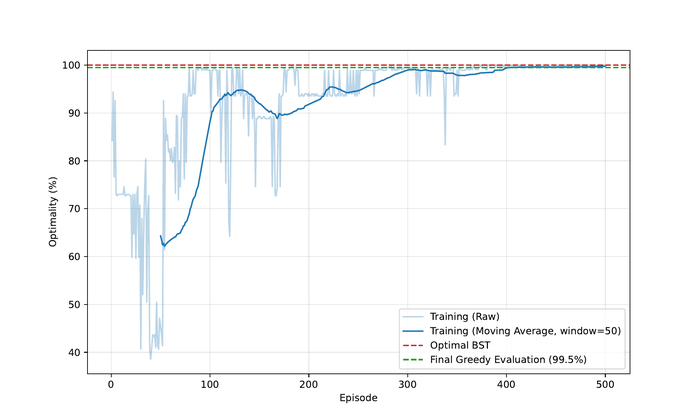

Figure /content/figures/optimal_bst.pdf:

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()

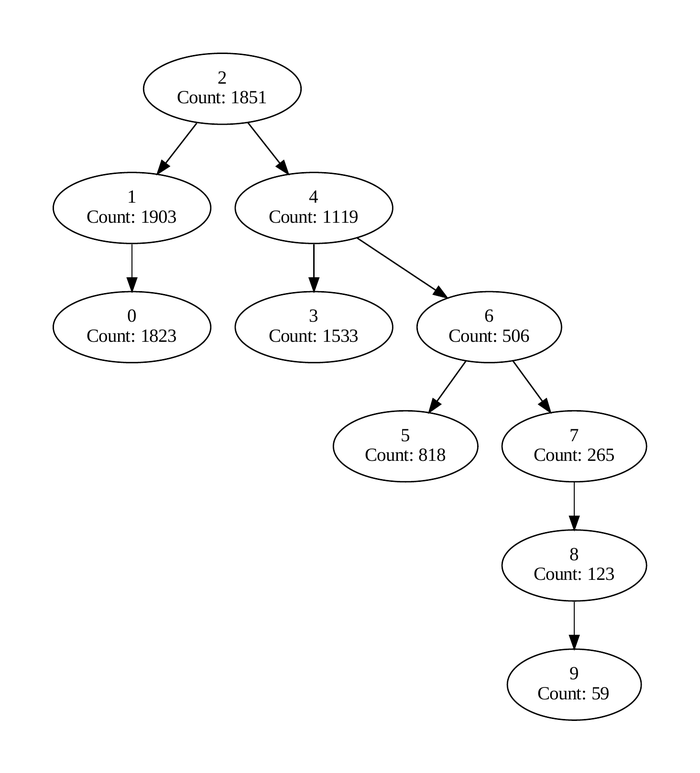

Figure /content/figures/training_metrics.pdf:

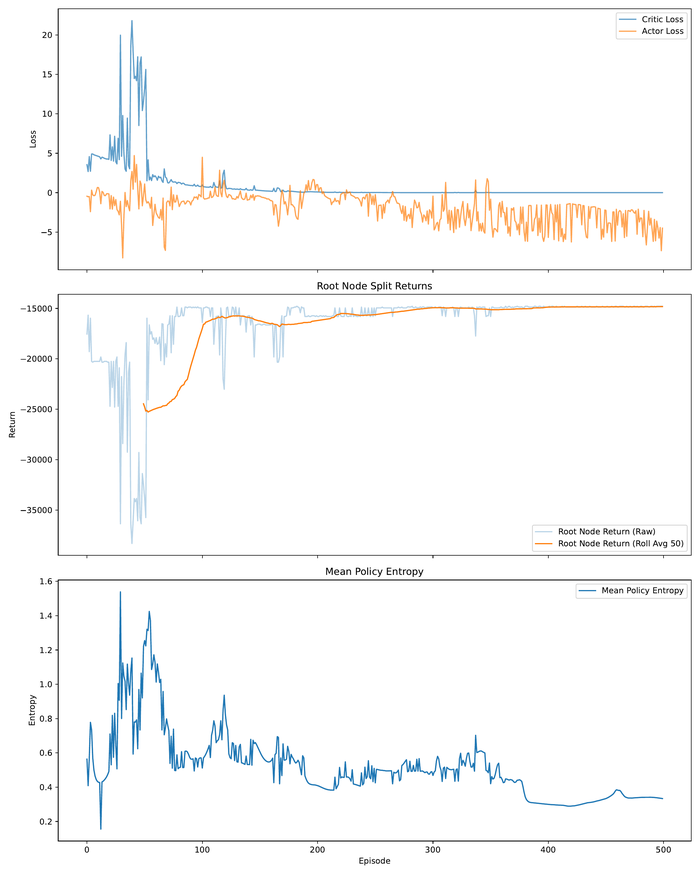

Figure /content/figures/action_policy_history.pdf:

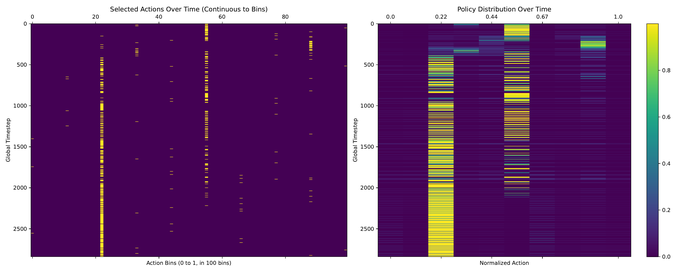

Figure /content/figures/query_distribution.pdf:

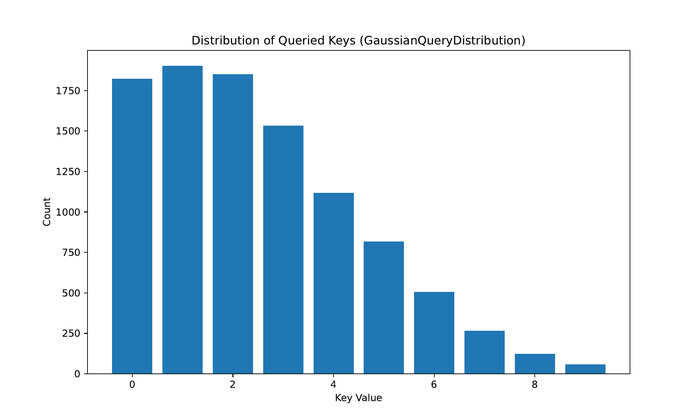

Figure /content/figures/search_tree_final_greedy_eval.pdf:

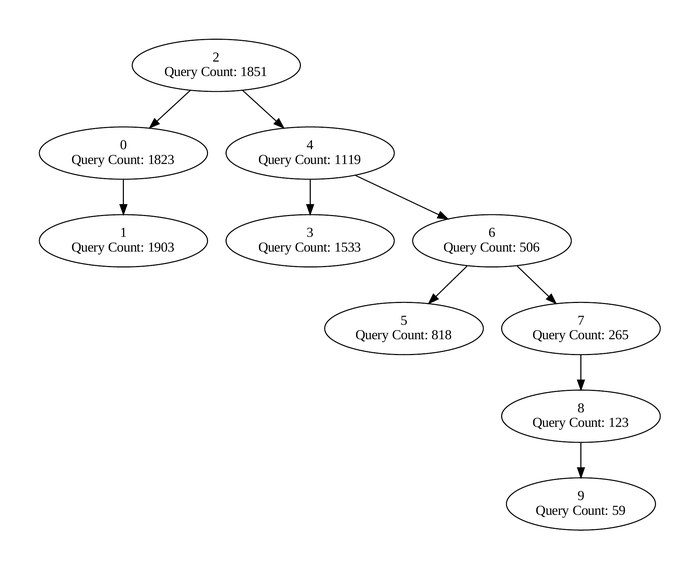

In [ ]:
experiment = Experiment(config=config, query_dist=query_dist)

# Plot the query distribution
plot_query_distribution(experiment.env)

# Train the A2C Agent
experiment.train()

# Get the agent's tree cost
agent_costs = experiment.env.compute_costs()
agent_root_cost = agent_costs[experiment.env.root_node.key]

# Build standard binary search tree and compare costs
experiment.compare_with_binary_search(agent_root_cost)

# Show generated figures
display_figures(experiment)

After running the above code, the training plots and optimized search
tree are saved to the directory `figures`.